In [2]:
from transformers import ViTForImageClassification, ViTFeatureExtractor, Trainer, TrainingArguments
from torchvision.transforms import Compose, Resize, ToTensor
from datasets import load_dataset


# Code is almost entirely from https://colab.research.google.com/github/nateraw/huggingface-hub-examples/blob/main/vit_image_classification_explained.ipynb#scrollTo=9mT-g1j2U5xd

In [3]:
cifar10 = load_dataset("cifar10")

README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [4]:
train_split = cifar10['train'].train_test_split(test_size=0.1, seed=1)

train_set = train_split['train']
val_set = train_split['test']
test_set = cifar10['test']

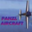

In [5]:
cifar_ex = cifar10['train'][400]
cifar_image = cifar_ex['img']
cifar_image

In [6]:
labels = cifar10['train'].features['label']
labels
labels.int2str(cifar_ex['label'])

'airplane'

In [7]:
from transformers import ViTImageProcessor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)
print(processor)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



In [8]:
print(processor(cifar_image, return_tensors='pt')['pixel_values'].shape)

torch.Size([1, 3, 224, 224])


In [9]:
def process_example(example):
    inputs = processor(example['img'], return_tensors='pt')
    inputs['label'] = example['label']
    return inputs


In [10]:
def transform(batch):
    inputs = processor([img for img in batch['img']], return_tensors='pt')
    inputs['label'] = batch['label']
    return inputs

In [11]:
train_transformed = train_set.with_transform(transform)
val_transformed   = val_set.with_transform(transform)
test_transformed  = test_set.with_transform(transform)

In [12]:
import torch

def collate_fn(batch):
  return {
      'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
      'labels': torch.tensor([x['label'] for x in batch])
  }

In [13]:
import numpy as np
!pip install evaluate
from evaluate import load

metric = load("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.4 MB/s eta 0:00:00


In [14]:
from transformers import ViTForImageClassification

labels = train_set.features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
from transformers import TrainingArguments
import os
import tempfile
os.environ["WANDB_MODE"] = "disabled"

training_args = TrainingArguments(
  output_dir=tempfile.gettempdir(),
  per_device_train_batch_size=45,
  evaluation_strategy="steps",
  num_train_epochs=1,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=100,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to="none",
  load_best_model_at_end=True,
)


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Without Fine Tuning

In [16]:
# evaluater = Trainer(
#     model=model,
#     args=training_args,
#     data_collator=collate_fn,
#     compute_metrics=compute_metrics,
#     train_dataset=train_transformed,
#     eval_dataset=val_transformed,
#     tokenizer=processor,
# )
# metrics = evaluater.evaluate(test_transformed)

# print(metrics)



# With fine-tuning

In [17]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=None,
    train_dataset=train_transformed,
    eval_dataset=val_transformed,
    tokenizer=processor,
)

/tmp/ipykernel_23/2042234366.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [20]:
import time

tic = time.time()
train_results = trainer.train()
toc = time.time()
print(f"That took {float(toc) - float(time)} seconds.")
metrics = trainer.evaluate(test_transformed)
print(metrics)



Step,Training Loss,Validation Loss
100,0.095600,0.259446
200,0.112600,0.169781
300,0.085600,0.159206
400,0.083700,0.158476
500,0.066100,0.149626
600,0.105200,0.118076
700,0.099100,0.090173
800,0.082200,0.071454
900,0.063400,0.063134
1000,0.059600,0.056240


TypeError: float() argument must be a string or a real number, not 'module'

In [22]:
torch.save(model.state_dict(), 'cifar10_weights.pth')

In [25]:
from IPython.display import FileLink
FileLink(r'cifar10_weights.pth')

/kaggle/working/cifar10_weights.pth

In [26]:
from scipy.ndimage import gaussian_filter1d

def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

def jitter(X, ox, oy):
    """
    Helper function to randomly jitter an image.

    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes

    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X

In [72]:
import random
import matplotlib.pyplot as plt
def create_class_visualization(target_y, model, dtype,img, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.

    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations

    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.type(dtype)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 100)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)

    # Randomly initialize the image as a PyTorch Tensor, and make it requires gradient.

    for t in range(num_iterations):
        # gc.collect()
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.data.copy_(jitter(img.data, ox, oy))

        

        img.to('cuda')
        out  = model(img)['logits']
        
        # Calculate the gradient of score - regularization
        reg = l2_reg * (img ** 2).sum()
        # print(out)
        loss = out[:, target_y] - reg
        # score_grad = torch.autograd.grad(out[:,target_y] - reg, img)[0]
        loss.backward()
                
        # Gradient ascent to find argmax
        with torch.no_grad():
            img +=  img.grad * learning_rate
        
        img.grad.zero_()
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        # Undo the random jitter
        img.data.copy_(jitter(img.data, -ox, -oy))
        # for c in range(3):
        #     lo = float(-MEAN[c] / STD[c])
        #     hi = float((1.0 - MEAN[c]) / STD[c])
        #     img.data[:, c].clamp_(min=lo, max=hi)

        if t % blur_every == 0:
            blur_image(img.data, sigma=0.5)

        # Periodically show the image
        if t == num_iterations - 1:
            to_show = img.squeeze().permute(1,2,0).clip(0,1)
            # img_to_show = img.squeeze().detach().cpu()
            plt.figure()
            plt.imshow(to_show.data.clone().cpu())
            plt.title('\nIteration %d / %d' % ( t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')

            plt.savefig(f"./google_c{target_y + 1}")
            plt.show()


        
    return torch.nn.functional.avg_pool2d(img.data.cpu(), 2, 1)

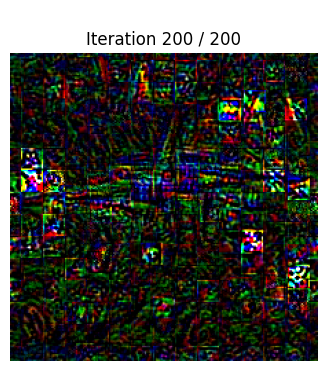

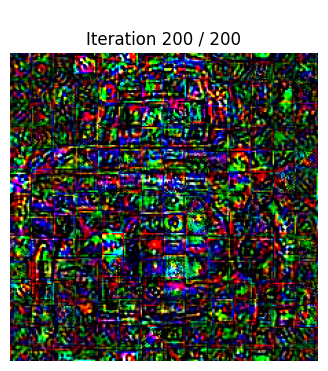

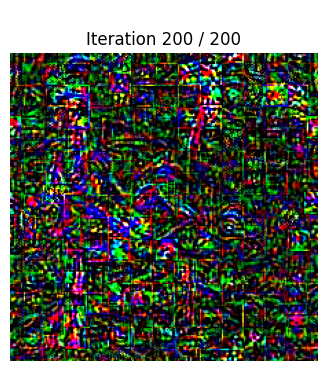

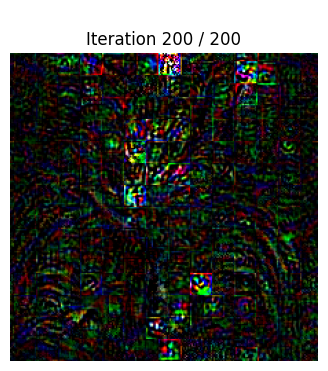

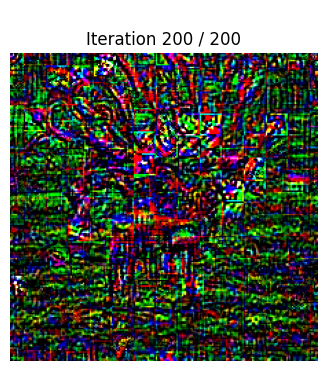

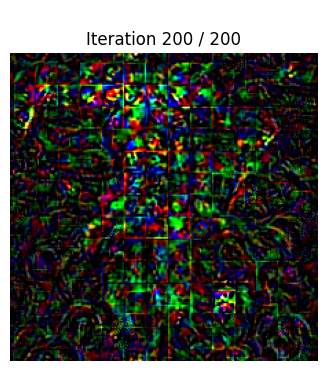

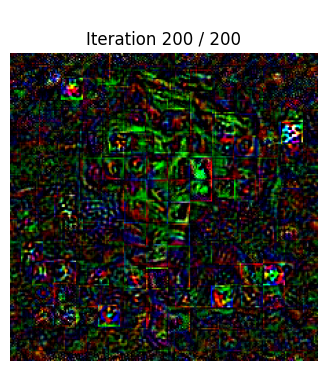

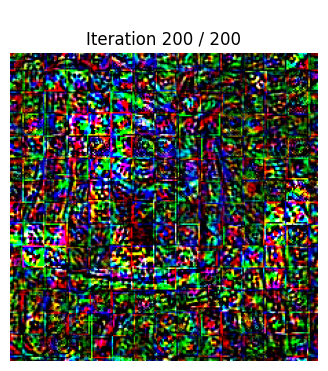

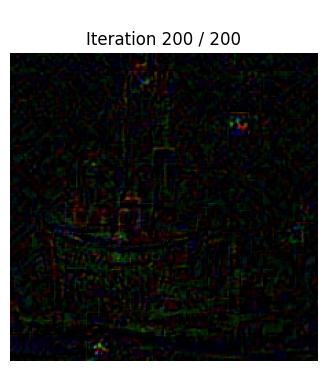

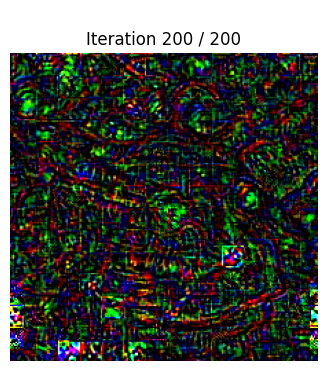

In [73]:
dtype = torch.FloatTensor
model.type(dtype)

target_y = 1
model.to('cuda')
img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype).requires_grad_()
# torch.set_num_threads(5)

for target_y in range(0,10):
    img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype).requires_grad_()
    img = create_class_visualization(target_y, model, dtype, img, num_iterations=200)

In [86]:
# for target_y in range(0,10):
FileLink(r"./google_c1.png")
# FileLink(r"./google_c2.png")
# FileLink(r"./google_c3.png")
# FileLink(r"./google_c4.png")
# FileLink(r"./google_c5.png")
# FileLink(r"./google_c6.png")
# FileLink(r"./google_c7.png")
# FileLink(r"./google_c8.png")
# FileLink(r"google_c9.png")
# FileLink(r"google_c10.png")

/kaggle/working/google_c1.png